# Palleja & Suez GMM at baseline v.s. V1-V2 distance of GMM random forest permutation + a full part of LOOCV

## 1. Read in data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
genus = pd.read_csv('/Users/Jessica/Documents/Lab/Multiple_longitudinal/Microbe_resilience/Palleja_Suez_GMM_baseline_predict_GMM_vegdist_bray_forML.txt',
                   delimiter = "\t")

In [17]:
genus.head()

,Study,ID,Dist_V1V2,Timepoint,Run,MF0001,MF0002,MF0003,MF0004,MF0005,...,MF0124,MF0125,MF0126,MF0127,MF0128,MF0129,MF0130,MF0131,MF0132,MF0133
0,Suez,603,0.061220,Baseline,ERR2749744,121,83,103,3,26,...,156,64,48,81,0,20,19,12,77,25
1,Suez,604,0.167643,Baseline,ERR2749783,73,44,88,4,22,...,161,113,29,100,6,29,24,9,86,56
2,Suez,605,0.213152,Baseline,ERR2749816,79,45,99,2,30,...,160,88,26,92,7,6,19,3,100,60
3,Suez,606,0.359143,Baseline,ERR2749856,75,47,96,3,25,...,150,83,22,83,1,16,29,7,58,60
4,Suez,704,0.331984,Baseline,ERR2750073,77,46,101,3,23,...,154,101,30,91,2,24,25,7,85,55


## 2. Set up evaluation environment. Use stratified 5-fold CV

In [18]:
my_data = genus.drop(columns=['Timepoint', 'Study', "Run"])

In [19]:
my_data.head()

,ID,Dist_V1V2,MF0001,MF0002,MF0003,MF0004,MF0005,MF0006,MF0007,MF0008,...,MF0124,MF0125,MF0126,MF0127,MF0128,MF0129,MF0130,MF0131,MF0132,MF0133
0,603,0.061220,121,83,103,3,26,20,86,86,...,156,64,48,81,0,20,19,12,77,25
1,604,0.167643,73,44,88,4,22,19,112,112,...,161,113,29,100,6,29,24,9,86,56
2,605,0.213152,79,45,99,2,30,18,107,108,...,160,88,26,92,7,6,19,3,100,60
3,606,0.359143,75,47,96,3,25,14,106,106,...,150,83,22,83,1,16,29,7,58,60
4,704,0.331984,77,46,101,3,23,15,103,104,...,154,101,30,91,2,24,25,7,85,55


In [20]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

## Step 3: Try out Random Forest (within the 5 - Fold CV setup)

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from collections import OrderedDict

In [22]:
seed = 42

In [23]:
X, y = my_data.drop(columns=['ID','Dist_V1V2']), my_data.Dist_V1V2

In [24]:
X.head()

,MF0001,MF0002,MF0003,MF0004,MF0005,MF0006,MF0007,MF0008,MF0009,MF0010,...,MF0124,MF0125,MF0126,MF0127,MF0128,MF0129,MF0130,MF0131,MF0132,MF0133
0,121,83,103,3,26,20,86,86,15,0,...,156,64,48,81,0,20,19,12,77,25
1,73,44,88,4,22,19,112,112,5,0,...,161,113,29,100,6,29,24,9,86,56
2,79,45,99,2,30,18,107,108,3,0,...,160,88,26,92,7,6,19,3,100,60
3,75,47,96,3,25,14,106,106,12,0,...,150,83,22,83,1,16,29,7,58,60
4,77,46,101,3,23,15,103,104,7,0,...,154,101,30,91,2,24,25,7,85,55


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import random
import math
seed = 42
X, y = my_data.drop(columns=['ID','Dist_V1V2']), my_data.Dist_V1V2
kf = KFold(n_splits=5)

In [26]:
# Max_depth = 2, max_features = "log2"
RF_1 = RandomForestRegressor(random_state=seed, max_depth=10, n_estimators= 1125, 
                            oob_score=True, max_features = "log2")
result_negMSE_1 = cross_val_score(RF_1, X, y, cv = kf, scoring="neg_mean_absolute_error")
print("Avg kfold neg MSE: {}".format(result_negMSE_1.mean())) #Print average accuracy

Avg kfold neg MSE: -0.07955850663291777


In [27]:
# R-squared (R2) score for the regression
result_r2 = cross_val_score(RF_1, X, y, cv=kf, scoring="r2")
avg_r2 = round(result_r2.mean(), 3)
print("Avg kfold R2 Score: {}".format(avg_r2))

Avg kfold R2 Score: -3.779


In [28]:
# Get the Spearman's rho for the training data in each cross-validation fold
# Correlating V1-V2 distance and feature baseline abundance
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import numpy as np

seed = 42
X, y = my_data.drop(columns=['ID','Dist_V1V2']), my_data.Dist_V1V2
kf = KFold(n_splits=5, random_state=seed, shuffle=True)

# Specify the top 10 features 
selected_features = ['MF0042', 'MF0048', 'MF0030',
                    'MF0033', 'MF0019', 'MF0115',
                    'MF0084', 'MF0085', 'MF0011', 'MF0132']

# Initialize lists to store Spearman's rho values for selected features
# Initializes a dictionary where each feature in selected_features is a key, and the corresponding value is an empty list 
spearman_rho_per_feature = {feature: [] for feature in selected_features}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for feature in selected_features:
        rho, _ = spearmanr(X_train[feature], y_train)
        spearman_rho_per_feature[feature].append(rho)

# Print mean, std, and range for each selected feature
for feature in selected_features:
    mean_rho = np.mean(spearman_rho_per_feature[feature])
    std_rho = np.std(spearman_rho_per_feature[feature])
    range_str = "({:.2f}, {:.2f})".format(mean_rho - std_rho, mean_rho + std_rho)
    print("Feature: {}, Mean Spearman's rho ± std on Training Data: {:.2f} ± {:.2f} {}".format(feature, mean_rho, std_rho, range_str))

Feature: MF0042, Mean Spearman's rho ± std on Training Data: -0.45 ± 0.21 (-0.66, -0.24)
Feature: MF0048, Mean Spearman's rho ± std on Training Data: 0.58 ± 0.10 (0.48, 0.67)
Feature: MF0030, Mean Spearman's rho ± std on Training Data: -0.45 ± 0.08 (-0.53, -0.37)
Feature: MF0033, Mean Spearman's rho ± std on Training Data: -0.29 ± 0.20 (-0.49, -0.09)
Feature: MF0019, Mean Spearman's rho ± std on Training Data: -0.62 ± 0.10 (-0.72, -0.52)
Feature: MF0115, Mean Spearman's rho ± std on Training Data: -0.56 ± 0.10 (-0.66, -0.46)
Feature: MF0084, Mean Spearman's rho ± std on Training Data: -0.45 ± 0.10 (-0.55, -0.35)
Feature: MF0085, Mean Spearman's rho ± std on Training Data: -0.38 ± 0.08 (-0.46, -0.30)
Feature: MF0011, Mean Spearman's rho ± std on Training Data: -0.27 ± 0.19 (-0.46, -0.07)
Feature: MF0132, Mean Spearman's rho ± std on Training Data: -0.48 ± 0.10 (-0.58, -0.37)


### Correlate real Dist_V1V2 and preidicted Dist_V1V2 to check model performance

In [13]:
from sklearn.model_selection import cross_val_predict
from scipy.stats import spearmanr
#from scipy.stats import pearsonr

In [14]:
# Get cross-validated predictions for each data point
y_pred = cross_val_predict(RF_1, X, y, cv=kf)

In [15]:
#y_pred

In [16]:
#y

In [17]:
# Calculate the Spearman correlation coefficient for the actual vs. predicted across all individuals
correlation, p_value = spearmanr(y, y_pred)

In [18]:
print(f"Spearman correlation coefficient for all individuals: {correlation:.3f}")
print(f"P-value for the Spearman correlation: {p_value:.3f}")

Spearman correlation coefficient for all individuals: 0.451
P-value for the Spearman correlation: 0.060


Text(0.0612198365950979, 0.2804746198999869, 'Spearman correlation: 0.45')

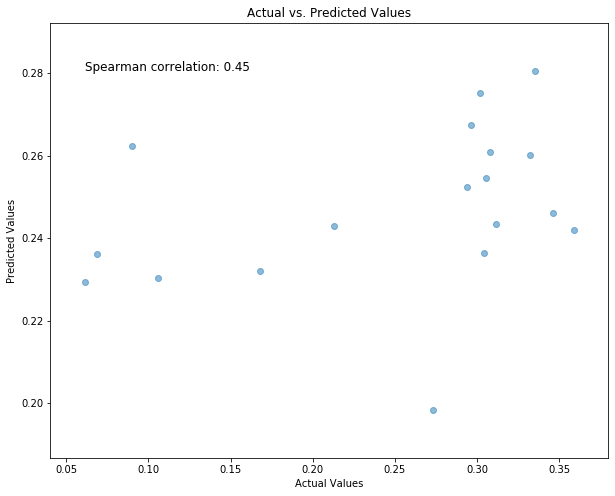

In [19]:
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(y, y_pred, alpha=0.5)  # Plot y vs. y_pred

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Optionally, you can annotate the Spearman correlation on the plot
corr, _ = spearmanr(y, y_pred)
plt.text(min(y), max(y_pred), f'Spearman correlation: {corr:.2f}', fontsize=12)


## Step 4: Permutation
**First shuffle Dist_V1V2 against other columns, and then do random forest. Repeat this 1000 times**

In [13]:
# Permutation
from collections import OrderedDict

seed=42
kf = KFold(n_splits=5)
# Max_depth = 10, max_features = "log2", n_estimators=1125, the same setting as the one above
RF_shuffle = RandomForestRegressor(random_state=seed, max_depth=10, n_estimators= 1125, 
                            oob_score=False, max_features = "log2")

permu_times = 1000

#Create an empty array first
#https://stackoverflow.com/questions/568962/how-do-i-create-an-empty-array-matrix-in-numpy
permutation_negMSE=a = np.empty(shape=(permu_times,1))

for i in range(1, permu_times + 1):
        #First copy my_data using pandas.DataFrame.copy (the correct way to do this!)
        #https://moonbooks.org/Articles/How-to-copy-a-dataframe-with-pandas-in-python-/
        shuffled_data = my_data.copy()

        #Then shuffle data
        shuffled_data['Dist_V1V2'] = shuffled_data['Dist_V1V2'].sample(frac=1, random_state=i).reset_index(drop=True)
        
        #Then run random forest
        X_shuffle, y_shuffle = shuffled_data.drop(columns=['ID','Dist_V1V2']), shuffled_data.Dist_V1V2
        result_negMSE_shuffle = cross_val_score(RF_shuffle, X_shuffle, y_shuffle, cv = kf, scoring="neg_mean_absolute_error")
        
        # Record the neg MSE for each permutation
        negMSE=result_negMSE_shuffle.mean() #Print average negMSE
        permutation_negMSE[i-1]=negMSE

In [14]:
len(permutation_negMSE)

1000

Text(0.5, 1.0, 'Permutation negative MSE histogram')

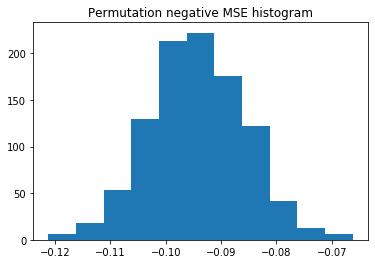

In [15]:
# Plot a histogram
binwidth=0.005
plt.hist(permutation_negMSE, bins=np.arange(min(permutation_negMSE), max(permutation_negMSE) 
                                            + binwidth, binwidth))
plt.title("Permutation negative MSE histogram") 

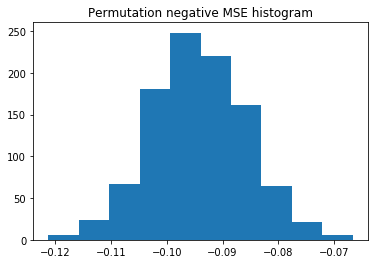

In [16]:
# Calculate area under histogram to get (some sort of) p value
values, bins, _ = plt.hist(permutation_negMSE)
plt.title("Permutation negative MSE histogram") 
area = sum(np.diff(bins)*values)

In [33]:
# What is the p = 0.05 threshold?
np.percentile(permutation_negMSE, 95)

## Step 5: Random Forest (using leave-one-out cross-validation)

In [29]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

seed = 42
X, y = my_data.drop(columns=['ID','Dist_V1V2']), my_data.Dist_V1V2

# Initialize LeaveOneOut object
loo = LeaveOneOut()

# Initialize an array of zeros to hold feature importances
# X.shape[1]: This is the number of columns (features)
# loo.get_n_splits(X): This is the number of splits in LOOCV
individual_feature_importances = np.zeros((X.shape[1], loo.get_n_splits(X)))

# Initialize an empty list to hold the negative MAE scores
neg_mae_scores_loo = []

# Initialize an array to store all LOOCV predictions (for correlation of y and y_pred later)
y_preds_array = np.zeros(len(y))

# Loop over the LOOCV folds
for fold, (train_index, test_index) in enumerate(loo.split(X)):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize the model with the same hyperparameters
    RF = RandomForestRegressor(random_state=seed, max_depth=10, n_estimators=1125,
                               oob_score=True, max_features="log2")
    # Fit the model
    RF.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = RF.predict(X_test)
    y_preds_array[test_index] = y_pred
    
    # Calculate the MAE for the current fold and append it to the list
    mae = mean_absolute_error(y_test, y_pred)
    neg_mae_scores_loo.append(-mae)  # We negate the MAE to follow your requirement
    
    # Accumulate feature importances for this fold
    individual_feature_importances[:, fold] = RF.feature_importances_

# Calculate median of feature importances
median_importances = np.median(individual_feature_importances, axis=1)

# Sort the mean feature importances in descending order and get the indices
sorted_median_idx = np.argsort(median_importances)[::-1]

# Get the names of the top 10 features based on mean importance
top_10_median_feature_names = X.columns[sorted_median_idx][:10]

# Get the mean importance scores of the top 10 features
top_10_median_importances = median_importances[sorted_median_idx][:10]

# After collecting all predictions, calculate the Spearman correlation
correlation, p_value = spearmanr(y, y_preds_array)

In [30]:
# Print out the negative MAE scores for each fold
#print("Negative MAE scores for each fold: ", neg_mae_scores_loo)

# The average negative MAE score across all folds
print("Average negative MAE: ", np.mean(neg_mae_scores_loo))

Average negative MAE:  -0.0834249042440775


In [31]:
individual_feature_importances.shape

(131, 18)

In [32]:
# Print the top 10 features and their importances
# Use zip because top_10_feature_names and top_10_importances are two iterables that we want to loop over simultaneously.
for name, importance in zip(top_10_median_feature_names, top_10_median_importances):
    print(f"{name}: {importance}")

MF0042: 0.04127194745558051
MF0048: 0.03664207159617419
MF0030: 0.024155728095360395
MF0115: 0.021383670968398383
MF0019: 0.020769004724541403
MF0084: 0.02071501570074539
MF0033: 0.01929322390260725
MF0132: 0.016794799949117763
MF0085: 0.01651149567488583
MF0011: 0.016441235265333448


In [33]:
#Print the correlation rho and p-value
print(f"Spearman correlation: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")


Spearman correlation: 0.342
P-value: 0.165


## Step 4: Permutation for LOOCV
**First shuffle Dist_V1V2 against other columns, and then do random forest. Repeat this 1000 times**

In [34]:
# Define the number of permutations
permu_times = 1000

# Create an empty array to store the neg MAE for each permutation
permutation_negMAE_loo = np.empty(permu_times)

# Initialize LOO cross-validation
loo = LeaveOneOut()

# Initialize the random forest with the specified settings
RF_shuffle_loo = RandomForestRegressor(random_state=seed, max_depth=10, n_estimators=1125,
                                       oob_score=False, max_features="log2")

# Run the permutation test with LOO CV
for i in range(permu_times):
    
    # Print the value of i at every 50th iteration so that I know the progress
    # % is modulo calculation
    if i % 50 == 0:
        print(f"Current iteration: {i}")
    
    # Shuffle the 'Dist_V1V2' column
    shuffled_target = my_data['Dist_V1V2'].sample(frac=1, random_state=i).reset_index(drop=True)
    
    # Prepare the data for cross-validation
    X, y_shuffled = my_data.drop(columns=['ID','Dist_V1V2']), shuffled_target
    
    # Variable to accumulate the mean absolute error
    mae_sum = 0
    
    # Perform LOO cross-validation
    for train_index, test_index in loo.split(X):
        # Split the data into train and test for the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]
        
        # Fit the model
        RF_shuffle_loo.fit(X_train, y_train)
        
        # Make predictions
        y_pred = RF_shuffle_loo.predict(X_test)
        
        # Calculate the MAE for the current fold and accumulate it
        mae_sum += mean_absolute_error(y_test, y_pred)
    
    # Calculate the average MAE over all folds and store the negative value
    permutation_negMAE_loo[i] = -mae_sum / loo.get_n_splits(X)

Current iteration: 0
Current iteration: 50
Current iteration: 100
Current iteration: 150
Current iteration: 200
Current iteration: 250
Current iteration: 300
Current iteration: 350
Current iteration: 400
Current iteration: 450
Current iteration: 500
Current iteration: 550
Current iteration: 600
Current iteration: 650
Current iteration: 700
Current iteration: 750
Current iteration: 800
Current iteration: 850
Current iteration: 900
Current iteration: 950


In [35]:
len(permutation_negMAE_loo)

1000

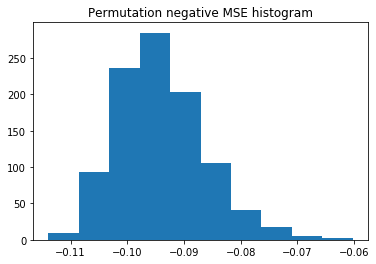

In [36]:
# Calculate area under histogram to get (some sort of) p value
values, bins, _ = plt.hist(permutation_negMAE_loo)
plt.title("Permutation negative MSE histogram") 
area = sum(np.diff(bins)*values)

In [37]:
# What is the p = 0.05 threshold?
np.percentile(permutation_negMAE_loo, 95)

-0.0800661957700576

#### See if the RF (LOOCV) is significant

In [38]:
# Calculate the mean of the negative MAE scores from the actual LOOCV
actual_neg_mae_mean = np.mean(neg_mae_scores_loo)

# Calculate the 95th percentile of the negative MAE scores from the permutation test
percentile_95_loo = np.percentile(permutation_negMAE_loo, 95)

# Compare and print the result
if actual_neg_mae_mean > percentile_95_loo: #sig
    print(f"Actual neg MAE ({actual_neg_mae_mean}) is larger than 95% of the neg MAE from permutation ({percentile_95_loo})")
    print("\033[1mRF is significant\033[0m") #bold text
else: #Nonsig
    print(f"Actual neg MAE ({actual_neg_mae_mean}) is smaller than 95% of the neg MAE from permutation ({percentile_95_loo})")
    print("\033[1mRF is nonsignificant\033[0m") #bold text

Actual neg MAE (-0.0834249042440775) is smaller than 95% of the neg MAE from permutation (-0.0800661957700576)
RF is nonsignificant


In [39]:
# Calculate the percentage of permutation_negMAE_loo that is less than or equal to actual_neg_mae_mean
percentage_loo = np.mean(permutation_negMAE_loo <= actual_neg_mae_mean) * 100
p_value_loo = round(1 - percentage_loo/100, 3)
print(f"The actual_neg_mae_mean is in the {p_value_loo}% percentile of the permutation distribution, so the p value is {p_value_loo}")


The actual_neg_mae_mean is in the 0.092% percentile of the permutation distribution, so the p value is 0.092
